In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import segmentation_models as sm

sm.set_framework('tf.keras')
sm.framework()

model = Unet(backbone_name='resnet101', encoder_weights='imagenet', encoder_freeze=True, classes=151, activation='softmax', input_shape=(None, None, 3))
model.summary()

# para quitar capas
# func_model._layers.pop(1)func_model._layers.pop(1)

Segmentation Models: using `keras` framework.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
______________________________________________

In [3]:
from PIL import Image
import numpy as np
import cv2
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import shutil
import os

train_cont = 3000
test_cont = 600

x_train = []
for archivo in os.listdir('dataset_sunrgbd/train_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/train_rgb',archivo))
#     img = cv2.resize(img_to_array(img), dsize=imsize)
    img = transform.resize(img_to_array(img), imsize)
    x_train.append(np.asarray(img))
# x1_train = np.array(x1_train)
# print(x1_train.shape)

# x1_test = []
for archivo in os.listdir('dataset_sunrgbd/test_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/test_rgb',archivo))
#     img = cv2.resize(img_to_array(img), dsize=(96,128))
    img = transform.resize(img_to_array(img), imsize)
    x_train.append(np.asarray(img))
x_train = np.array(x_train)
print(x_train.shape)

# x_test = []
# cont = 0
# for archivo in os.listdir('dataset/ADEChallengeData2016/images/validation'):
#     img = Image.open(os.path.join('dataset/ADEChallengeData2016/images/validation',archivo))
#     img = cv2.resize(img_to_array(img), dsize=(96,128))
#     x_test.append(np.array(img))
#     cont += 1
#     if cont == test_cont: break
# x_test = np.array(x_test)
# print(x_test.shape)

y_train = []
for archivo in os.listdir('dataset_sunrgbd/train_label'):
    img = np.load(os.path.join('dataset_sunrgbd/train_label',archivo))
    #     img = cv2.resize(img_to_array(img), dsize=(96,128))
    img = transform.resize(img_to_array(img), imsize)
    y_train.append(img)
# y_train = np.array(y_train).astype('uint8')
# y_train = tf.keras.utils.to_categorical(y_train, dtype='float32')
# print(y_train.shape)

# y_test = []
for archivo in os.listdir('dataset_sunrgbd/test_label'):
    img = np.load(os.path.join('dataset_sunrgbd/test_label',archivo))
    #     img = cv2.resize(img_to_array(img), dsize=(96,128))
    img = transform.resize(img_to_array(img), imsize)
    y_train.append(img)
y_train = np.array(y_train).astype('uint8')
y_train = tf.keras.utils.to_categorical(y_train, dtype='float32')
print(y_train.shape)

# y_test = []
# cont = 0
# for archivo in os.listdir('dataset/ADEChallengeData2016/annotations/validation'):
#     img = Image.open(os.path.join('dataset/ADEChallengeData2016/annotations/validation',archivo))
#     img = cv2.resize(img_to_array(img), dsize=(96,128))
# #     img = cv2.cvtColor(img_to_array(img), cv2.COLOR_RGB2GRAY)
#     y_test.append(np.array(img))
#     cont += 1
#     if cont == test_cont: break
# # y_test = np.array(y_test).astype('uint8')
# y_test = tf.keras.utils.to_categorical(y_test, dtype='float32')
# print(y_test.shape)

del img

(3000, 128, 96, 3)
(500, 128, 96, 3)
(3000, 128, 96, 151)
(500, 128, 96, 151)


In [4]:
x_train.shape

(3000, 128, 96, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2)

MemoryError: Unable to allocate 16.6 GiB for an array with shape (2400, 128, 96, 151) and data type float32

In [6]:
from segmentation_models import get_preprocessing

BACKBONE = 'resnet34'

preprocess_input = get_preprocessing(BACKBONE)


x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [7]:
y_train.shape
type(x_train[0][0][0][0])

numpy.float32

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        validation_split=0.2,
        fill_mode="nearest")
        
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_datagen.fit(x_train)
val_datagen.fit(x_test)

In [10]:
train = train_datagen.flow(x_train, y_train, batch_size=8)
validation = train_datagen.flow(x_test, y_test, batch_size=8)

In [11]:
import matplotlib.pyplot as plt

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

In [12]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
#seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [13]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_best_weights.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]

In [14]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import precision, iou_score

model.compile(optimizer="Adam", loss=bce_logdice_loss, metrics=[dice_coef, 'accuracy', true_positive_rate, iou_score])
# model.compile(loss=bce_jaccard_loss, optimizer= "Adam", metrics =[precision])

# # Para utilizar el 20% para validación vamos a poner que realizen un split de 0,2
# history = model.fit(X_train, y_train, epochs=100, verbose=1,
#                     batch_size=8, validation_data=(X_val, y_val)#,
# #                     callbacks=callbacks_list
#                    )


history = model.fit(train, epochs=30, verbose=1, validation_data=validation, callbacks=callbacks_list)

Epoch 1/30
375/375 [==============================] - 120s 287ms/step - loss: 1.5158 - dice_coef: 0.2839 - accuracy: 0.3084 - true_positive_rate: 0.2872 - iou_score: 0.0062 - val_loss: 2.0457 - val_dice_coef: 0.1500 - val_accuracy: 0.1517 - val_true_positive_rate: 0.1509 - val_iou_score: 0.0030

Epoch 00001: val_dice_coef improved from -inf to 0.15005, saving model to seg_model_best_weights.hdf5
Epoch 2/30
375/375 [==============================] - 113s 302ms/step - loss: 1.1489 - dice_coef: 0.3400 - accuracy: 0.3414 - true_positive_rate: 0.3412 - iou_score: 0.0078 - val_loss: 1.4081 - val_dice_coef: 0.2667 - val_accuracy: 0.2683 - val_true_positive_rate: 0.2672 - val_iou_score: 0.0049

Epoch 00002: val_dice_coef improved from 0.15005 to 0.26668, saving model to seg_model_best_weights.hdf5
Epoch 3/30
375/375 [==============================] - 113s 300ms/step - loss: 1.1222 - dice_coef: 0.3480 - accuracy: 0.3494 - true_positive_rate: 0.3492 - iou_score: 0.0080 - val_loss: 1.2713 - val_d

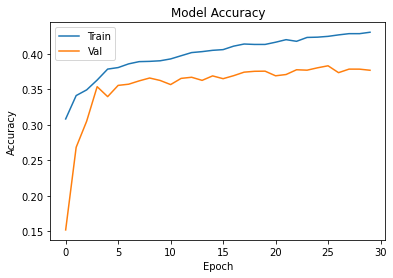

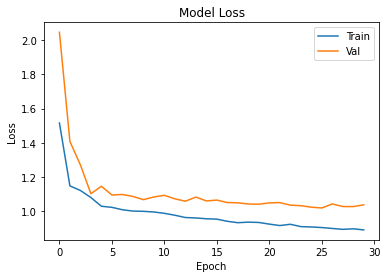

In [15]:
plot_acc(history)
plot_loss(history)

In [ ]:
# Para pasar la segmentacion a imagen
np.argmax(a, axis=1)